In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier

import pickle

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [4]:
df.describe()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,40907.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000
mean,0.555162,51.327255,0.213835,0.127719,0.821340,3.461134,0.514886,122.075901,30.406355,0.488609,0.500122
std,0.496954,21.623969,0.410017,0.333781,0.383072,0.780919,0.499784,57.561531,6.835072,0.499876,0.500006
min,0.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.500000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,1.000000,3.000000,0.000000,78.750000,25.900000,0.000000,0.000000
50%,1.000000,52.000000,0.000000,0.000000,1.000000,4.000000,1.000000,97.920000,29.400000,0.000000,1.000000
75%,1.000000,68.000000,0.000000,0.000000,1.000000,4.000000,1.000000,167.590000,34.100000,1.000000,1.000000
max,1.000000,103.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,92.000000,1.000000,1.000000


In [5]:
# Comprobamos cuantos registros hay con una edad menor a cero.

len(df[df['age'] < 0])

58

Encontramos valores negativas para las edades ('age'). Como tenemos bastantes registros para realizar el modelado vamos a eliminar las 58 filas afectadas. \
Campos 'age', 'avg_glucose_level' y 'bmi' --> debemos aplicar un escalado a dichas columnas para conseguir una normalización frente al resto de datos del dataset.

DUDAS --> std vs mean vs media

In [6]:
# Validamos si hay duplicados

df[df.duplicated(keep=False)]
# df.duplicated().sum()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


No hay duplicados.

In [7]:
# Validamos si hay valores NaN

df.isnull().sum()
# df.isnull().sum().any()

sex                  3
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

En la columna 'sex' hay 3 filas con valores nulos. Como tenemos bastantes registros para realizar el modelado vamos a eliminar las 3 filas afectadas.

### Features Engineering

In [8]:
def features_engineering(df, convertir_valor=False, campos_nuevos=True, escalar=True):
    df.rename(columns={'sex':'Género', 'age':'Edad', 'hypertension':'Hipertensión', 'heart_disease':'Cardiopatía', 'ever_married':'Casado', 'work_type':'Tipo de trabajo', 
                        'Residence_type':'Tipo de residencia', 'avg_glucose_level':'AVG-Nivel de glucosa', 'bmi':'IMC', 'smoking_status':'Fumador', 
                        'stroke':'Infarto'}, inplace=True)

    df.dropna(inplace=True) # Eliminamos las 3 filas con valores null en sex (género).
    df.drop(df[df['Edad'] < 0].index, inplace=True) # Eliminamos las 58 filas con edades menor a cero.

    if campos_nuevos:
        df['Glucosa_IMC'] = (df['AVG-Nivel de glucosa'] * df['IMC']) / 1000 # Obesidad

        df['Hiper_Cardiopatía'] = df['Hipertensión'] + df['Cardiopatía']

        my_dict = {
                0:'Ninguna',
                1:'Hiper o Cardio',
                2:'Ambas'
                }
        df['Hiper-Cardiopatía'] = df['Hiper_Cardiopatía'].map(my_dict)

    if convertir_valor == False:
        df['Género'] = np.where(df['Género'] == 0, 'Femenino', 'Masculino')

        df['Hipertensión'] = np.where(df['Hipertensión'] == 0, 'No', 'Sí')

        df['Cardiopatía'] = np.where(df['Cardiopatía'] == 0, 'No', 'Sí')

        df['Casado'] = np.where(df['Casado'] == 0, 'No', 'Sí')

        my_dict = {
                0:'Nunca',
                1:'Niños',
                2:'Funcionario',
                3:'Autónomo',
                4:'Privado'
                }
        df['Tipo de trabajo'] = df['Tipo de trabajo'].map(my_dict)

        df['Tipo de residencia'] = np.where(df['Tipo de residencia'] == 0, 'Rural', 'Urbana')

        df['Fumador'] = np.where(df['Fumador'] == 0, 'No', 'Sí')

        df['Infarto'] = np.where(df['Infarto'] == 0, 'No', 'Sí')

    if escalar:
        scaler = MinMaxScaler()
        df[['Edad', 'AVG-Nivel de glucosa', 'IMC', 'Glucosa_IMC']] = scaler.fit_transform(df[['Edad', 'AVG-Nivel de glucosa', 'IMC', 'Glucosa_IMC']])
        # df[['Edad', 'AVG-Nivel de glucosa', 'IMC', 'Glucosa_IMC']] = scaler.fit_transform(df[['Edad', 'AVG-Nivel de glucosa', 'IMC', 'Glucosa_IMC']])

    return df

Eliminamos las 3 filas con valores null en sex (género).

Eliminamos las 58 filas con edades menor a cero.

Conversión a valores binarios: Género, Hipertensión, Cardiopatía, Casado, Tipo de residencia y Fumador.

Conversión a enteros: Tipo de trabajo.

Escalados para dejar los datos acotados entre 0 y 1: Edad, AVG-Nivel de glucosa, IMC y Glucosa_IMC.

Campos nuevos:
    Glucosa_IMC: el producto entre la media del nivel de glucosa en sangre y el IMC.
    Hiper_Cardio: la suma de los valores binarios de hipertensión y cardiopatía. Resultado: ninguna de las dos enfermedades (0), una de las dos (1) o ambas (2).

### Cargamos de nuevo el dataset con el renombrado de las columnas y la transformación de los datos (sin escalado) para realizar el análisis exploratorio de datos

In [9]:
df = pd.read_csv('../data/train.csv')
df = features_engineering(df, escalar=False)
df.head()

,Género,Edad,Hipertensión,Cardiopatía,Casado,Tipo de trabajo,Tipo de residencia,AVG-Nivel de glucosa,IMC,Fumador,Infarto,Glucosa_IMC,Hiper_Cardiopatía,Hiper-Cardiopatía
0,Masculino,63.0,No,Sí,Sí,Privado,Urbana,228.69,36.6,Sí,Sí,8.370054,1,Hiper o Cardio
1,Masculino,42.0,No,Sí,Sí,Privado,Rural,105.92,32.5,No,Sí,3.442400,1,Hiper o Cardio
2,Femenino,61.0,No,No,Sí,Privado,Urbana,171.23,34.4,Sí,Sí,5.890312,0,Ninguna
3,Masculino,41.0,Sí,No,Sí,Autónomo,Rural,174.12,24.0,No,Sí,4.178880,1,Hiper o Cardio
4,Masculino,85.0,No,No,Sí,Privado,Urbana,186.21,29.0,Sí,Sí,5.400090,0,Ninguna


In [10]:
df.describe()

,Edad,AVG-Nivel de glucosa,IMC,Glucosa_IMC,Hiper_Cardiopatía
count,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000
mean,51.404074,122.070963,30.405795,3.807151,0.341281
std,21.543166,57.555158,6.835516,2.265941,0.548901
min,0.000000,55.120000,11.500000,0.701040,0.000000
25%,35.000000,78.750000,25.900000,2.217354,0.000000
50%,52.000000,97.950000,29.400000,2.880000,0.000000
75%,68.000000,167.410000,34.100000,4.978215,1.000000
max,103.000000,271.740000,92.000000,15.133512,2.000000


### Análisis Univariante

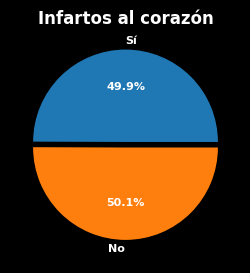

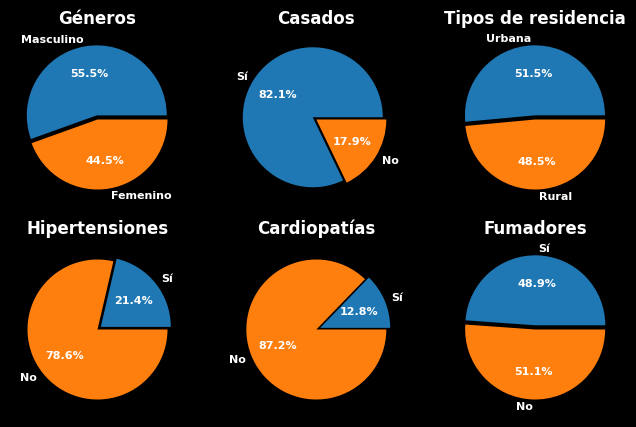

In [11]:
fig, axes = plt.subplots(figsize=(3, 3))

fig.patch.set_facecolor('black')

axes.pie(x=[df['Infarto'].value_counts()['Sí'], df['Infarto'].value_counts()['No']], #colors=['#004D7A', '#FFA6B9'] ,
                labels=['Sí', 'No'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.06, 0))
axes.set_title('Infartos al corazón', color='white', weight='bold');


fig, axes = plt.subplots(2, 3, figsize=(8, 5))

# fig.suptitle('test title', fontsize=20)

fig.patch.set_facecolor('black')

axes[0, 0].pie(x=[df['Género'].value_counts()['Masculino'], df['Género'].value_counts()['Femenino']], #colors=['#004D7A', '#FFA6B9'] ,
                labels=['Masculino', 'Femenino'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.06, 0))
axes[0, 0].set_title('Géneros', color='white', weight='bold')

axes[0, 1].pie(x=[df['Casado'].value_counts()['Sí'], df['Casado'].value_counts()['No']], 
                labels=['Sí', 'No'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.06, 0))
axes[0, 1].set_title('Casados', color='white', weight='bold')

axes[0, 2].pie(x=[df['Tipo de residencia'].value_counts()['Urbana'], df['Tipo de residencia'].value_counts()['Rural']], 
                labels=['Urbana', 'Rural'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.06, 0))
axes[0, 2].set_title('Tipos de residencia', color='white', weight='bold')

axes[1, 0].pie(x=[df['Hipertensión'].value_counts()['Sí'], df['Hipertensión'].value_counts()['No']], 
                labels=['Sí', 'No'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.06, 0))
axes[1, 0].set_title('Hipertensiones', color='white', weight='bold')

axes[1, 1].pie(x=[df['Cardiopatía'].value_counts()['Sí'], df['Cardiopatía'].value_counts()['No']], 
                labels=['Sí', 'No'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.06, 0))
axes[1, 1].set_title('Cardiopatías', color='white', weight='bold')

axes[1, 2].pie(x=[df['Fumador'].value_counts()['Sí'], df['Fumador'].value_counts()['No']], 
                labels=['Sí', 'No'], autopct='%.1f%%', data=df, textprops={'color': 'white', 'fontsize': 8, 'weight':'bold'}, explode=(0.06, 0))
axes[1, 2].set_title('Fumadores', color='white', weight='bold');

# axes[0, 3].pie(x=[df['Tipo de trabajo'].value_counts()['Privado'], df['Tipo de trabajo'].value_counts()['Autónomo'], df['Tipo de trabajo'].value_counts()['Funcionario'],
#                 df['Tipo de trabajo'].value_counts()['Niños'], df['Tipo de trabajo'].value_counts()['Nunca']], 
#                 labels=['Privado', 'Autónomo', 'Funcionario', 'Niños', 'Nunca'], autopct='%.1f%%', data=df, textprops={'fontsize': 7, 'color': 'white', 'weight':'bold'}, 
#                 explode=(0.03, 0.03, 0.03, 0, 1))
# axes[0, 3].set_title('Tipos de trabajo', color='white', weight='bold')

# axes[1, 3].pie(x=[df['Hiper-Cardiopatía'].value_counts()['Ninguna'], df['Hiper-Cardiopatía'].value_counts()['Hiper o Cardio'], df['Hiper-Cardiopatía'].value_counts()['Ambas']], 
#                 labels=['Ninguna', 'Hiper o Cardio', 'Ambas'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.02, 0.02, 0.02))
# axes[1, 3].set_title('Hipertensión - Cardiopatías', color='white', weight='bold');

Los valores en la columna a predecir están bastante equilibrados, al igual que en 'Géneros', 'Tipos de residencia' y 'Fumadores'.

Por otro lado, hay un porcentaje muy alto de casados. Al contrario para las personas con hipertensión y cardiopatías.

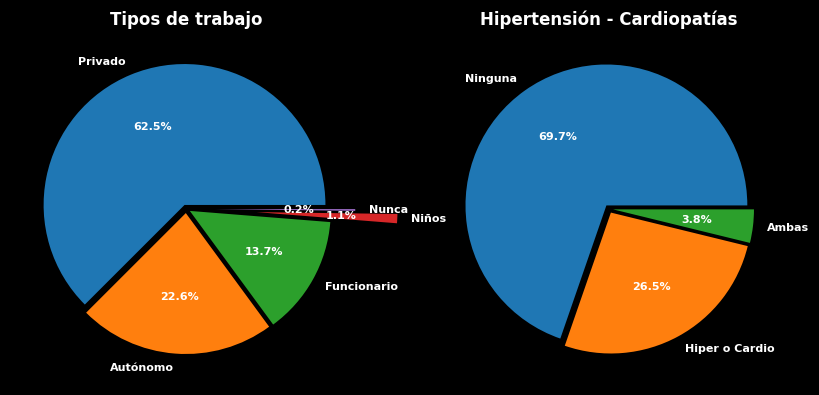

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.patch.set_facecolor('black')

axes[0].pie(x=[df['Tipo de trabajo'].value_counts()['Privado'], df['Tipo de trabajo'].value_counts()['Autónomo'], df['Tipo de trabajo'].value_counts()['Funcionario'],
                df['Tipo de trabajo'].value_counts()['Niños'], df['Tipo de trabajo'].value_counts()['Nunca']], 
                labels=['Privado', 'Autónomo', 'Funcionario', 'Niños', 'Nunca'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, 
                explode=(0.03, 0.03, 0.03, 0.5, 0.2))
axes[0].set_title('Tipos de trabajo', color='white', weight='bold')

axes[1].pie(x=[df['Hiper-Cardiopatía'].value_counts()['Ninguna'], df['Hiper-Cardiopatía'].value_counts()['Hiper o Cardio'], df['Hiper-Cardiopatía'].value_counts()['Ambas']], 
                labels=['Ninguna', 'Hiper o Cardio', 'Ambas'], autopct='%.1f%%', data=df, textprops={'fontsize': 8, 'color': 'white', 'weight':'bold'}, explode=(0.03, 0.03, 0.03))
axes[1].set_title('Hipertensión - Cardiopatías', color='white', weight='bold');


# fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# sns.countplot(x=df['Tipo de trabajo'], ax=axes[0], dodge=True)
# axes[0].set_title('Tipos de trabajos', weight='bold')
# axes[0].set_ylabel('Personas')
# axes[0].set_xlabel('')

# sns.countplot(x=df['Hiper-Cardiopatía'], ax=axes[1], dodge=True)
# axes[1].set_title('Hipertensión - Cardiopatías', weight='bold')
# axes[1].set_ylabel('Personas')
# axes[1].set_xlabel('');

El sector privado en 'Tipos de trabajo' se lleva más de la mitad de los datos con un poco más del 62%, seguido por Autónomo (22.6%) y funcionarios (13.7%), en total suman casi el 100%, para ser más exactos 98.8% de lo datos totales. Las personas que cuidan a niños (1.1%) y los que nunca han trabajado (0.2%) tienen un porcentaje muy bajo. Vemos que la suma total es 100.1% debido a los redondeos.

Las personas sin hipertensión ni cardiopatías suman 69.7%, casi el 70% de los datos totales. Las que tienen solo una de las dos están en el 26.5%. Sin embargo las que tienen las dos enfermedades no llegan al 4%.

In [13]:
# fig, axes = plt.subplots(figsize=(5, 5))

# plt.pie(x=[df['Infarto'].value_counts()['Sí'], df['Infarto'].value_counts()['No']], labels=['Sí', 'No'], autopct='%.1f%%', data=df)
# axes.set_title('Infartos al corazón')


# fig, axes = plt.subplots(1, 4, figsize=(30, 5))

# # plt.pie(x=[df['Género'].value_counts()['Masculino'], df['Género'].value_counts()['Femenino']], labels=['Masculino', 'Femenino'], autopct='%.1f%%', data=df)
# sns.countplot(x=df['Género'], ax=axes[0], dodge=True)
# axes[0].set_title('Géneros')
# axes[0].set_ylabel('Cuenta')

# sns.countplot(x=df['Casado'], ax=axes[1], dodge=True)
# axes[1].set_title('Casados')
# axes[1].set_ylabel('Cuenta')

# sns.countplot(x=df['Tipo de trabajo'], ax=axes[2], dodge=True)
# axes[2].set_title('Tipos de trabajos')
# axes[2].set_ylabel('Cuenta')

# sns.countplot(x=df['Tipo de residencia'], ax=axes[3], dodge=True)
# axes[3].set_title('Tipos de residencias')
# axes[3].set_ylabel('Cuenta')


# fig, axes = plt.subplots(1, 4, figsize=(30, 5))

# sns.countplot(x=df['Hipertensión'], ax=axes[0], dodge=True)
# axes[0].set_title('Hipertensiones')
# axes[0].set_ylabel('Cuenta')

# sns.countplot(x=df['Cardiopatía'], ax=axes[1], dodge=True)
# axes[1].set_title('Cardiopatías')
# axes[1].set_ylabel('Cuenta')

# sns.countplot(x=df['Hiper-Cardiopatía'], ax=axes[2], dodge=True)
# axes[2].set_title('Hipertensión - Cardiopatías')
# axes[2].set_ylabel('Cuenta')

# sns.countplot(x=df['Fumador'], ax=axes[3], dodge=True)
# axes[3].set_title('Fumadores')
# axes[3].set_ylabel('Cuenta');

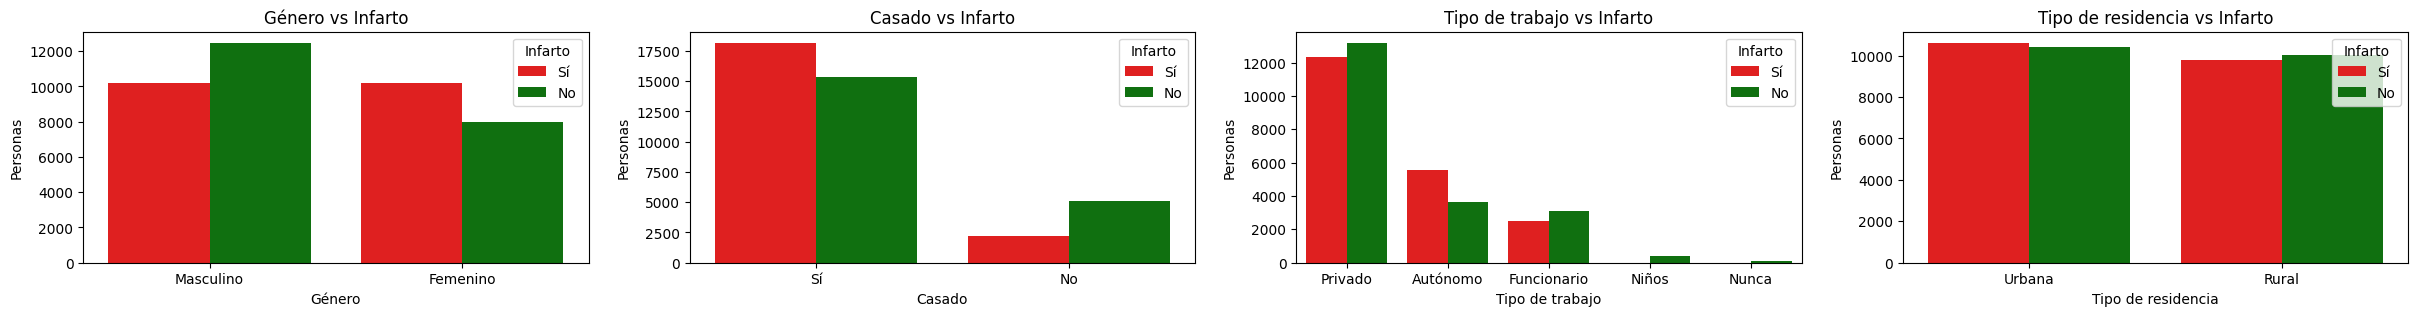

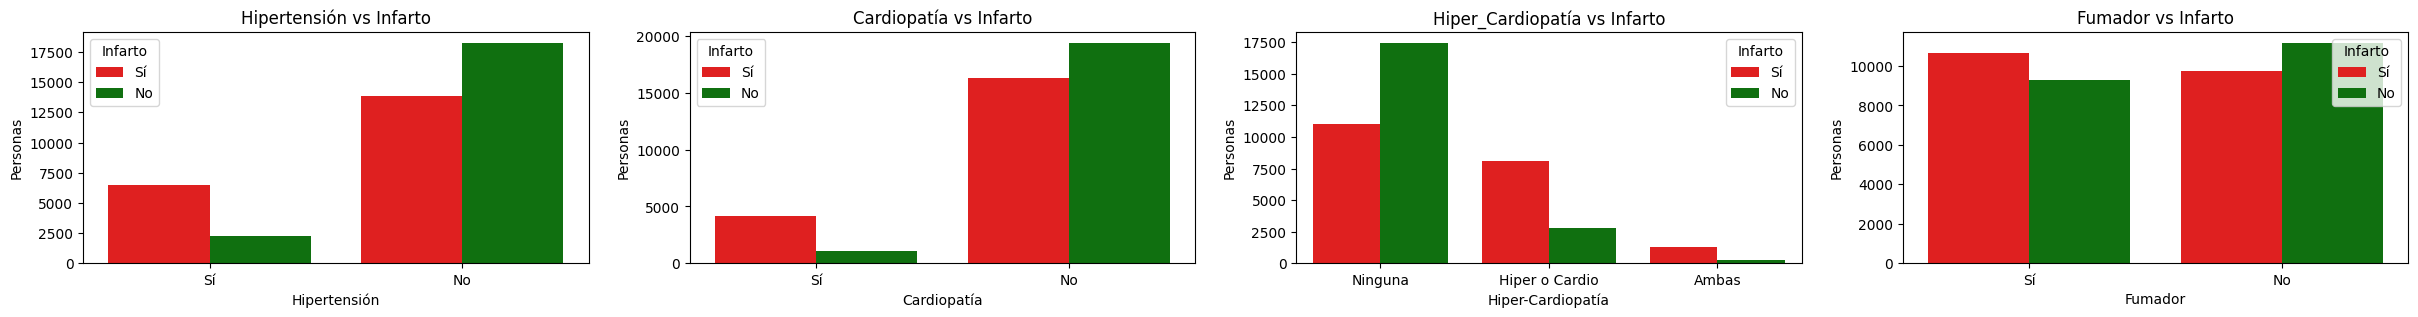

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(30, 3))

sns.countplot(x=df['Género'], hue=df['Infarto'], ax=axes[0], palette=['red', 'green'])
axes[0].set_title('Género vs Infarto')
axes[0].set_ylabel('Personas')

sns.countplot(x=df['Casado'], hue=df['Infarto'], ax=axes[1], palette=['red', 'green'])
axes[1].set_title('Casado vs Infarto')
axes[1].set_ylabel('Personas')

sns.countplot(x=df['Tipo de trabajo'], hue=df['Infarto'], ax=axes[2], palette=['red', 'green'])
axes[2].set_title('Tipo de trabajo vs Infarto')
axes[2].set_ylabel('Personas')

sns.countplot(x=df['Tipo de residencia'], hue=df['Infarto'], ax=axes[3], palette=['red', 'green'])
axes[3].set_title('Tipo de residencia vs Infarto')
axes[3].set_ylabel('Personas')


fig, axes = plt.subplots(1, 4, figsize=(30, 3))

sns.countplot(x=df['Hipertensión'].sort_values(ascending=False), hue=df['Infarto'], ax=axes[0], palette=['red', 'green'])
axes[0].set_title('Hipertensión vs Infarto')
axes[0].set_ylabel('Personas')

sns.countplot(x=df['Cardiopatía'], hue=df['Infarto'], ax=axes[1], palette=['red', 'green'])
axes[1].set_title('Cardiopatía vs Infarto')
axes[1].set_ylabel('Personas')

sns.countplot(x=df['Hiper-Cardiopatía'].sort_values(ascending=False), hue=df['Infarto'], ax=axes[2], palette=['red', 'green'])
axes[2].set_title('Hiper_Cardiopatía vs Infarto')
axes[2].set_ylabel('Personas')

sns.countplot(x=df['Fumador'], hue=df['Infarto'], ax=axes[3], palette=['red', 'green'])
axes[3].set_title('Fumador vs Infarto')
axes[3].set_ylabel('Personas');

El género no influye mucho. Hay más mujeres con riesgo de infarto a que no, al contrario de los hombres, pero en proporción de infartos están muy igualados.

La vida matrimonial y el tabaquismo tienen mayor porcentaje de sufrir un infarto, al igual que las enfermedades de hipertensión y cardiopatía. Podemos observar que las personas que tienen una de las dos, enfermedades o las dos tienen mayor riesgo, se podría decir que es el índice con mayor riesgo de todos los analizados.

El trabajo por Autónomo tiene mayor riesgo que el resto de trabajos.

Para el tipo de residencia hay una leve tendencia a sufrir un infarto en los entornos urbanos.

In [15]:
# pd.DataFrame(df[['Tipo de trabajo', 'Infarto']].value_counts())

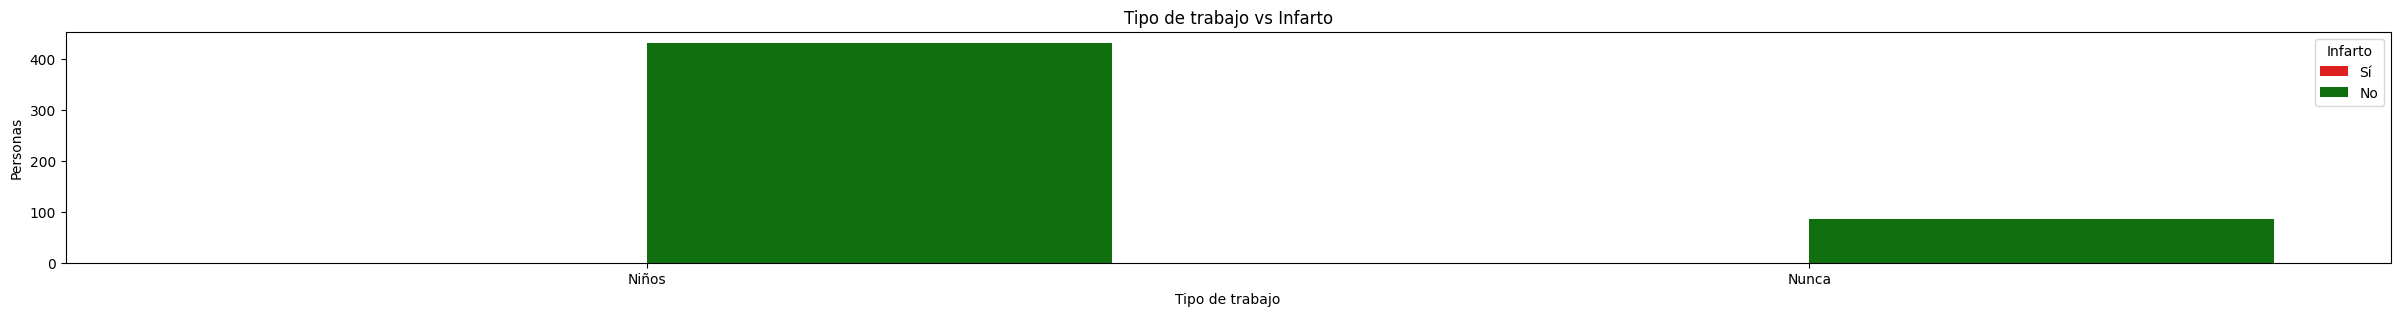

In [16]:
# Ampliamos la gráfica para los que nunca han trabajado y los que cuidan a niños.

fig, axes = plt.subplots(figsize=(30, 3))

sns.countplot(x=df['Tipo de trabajo'][(df['Tipo de trabajo'] == 'Niños') | (df['Tipo de trabajo'] == 'Nunca')], hue=df['Infarto'], ax=axes, palette=['red', 'green'])
axes.set_title('Tipo de trabajo vs Infarto')
axes.set_ylabel('Personas');

Ampliamos la gráfica para los que nunca han trabajado y los que cuidan a niños. \
Ninguno de los dos valores tuvo nunca un infarto. Estos datos pueden causar sesgos, por lo que sería conveniente eliminarlos.

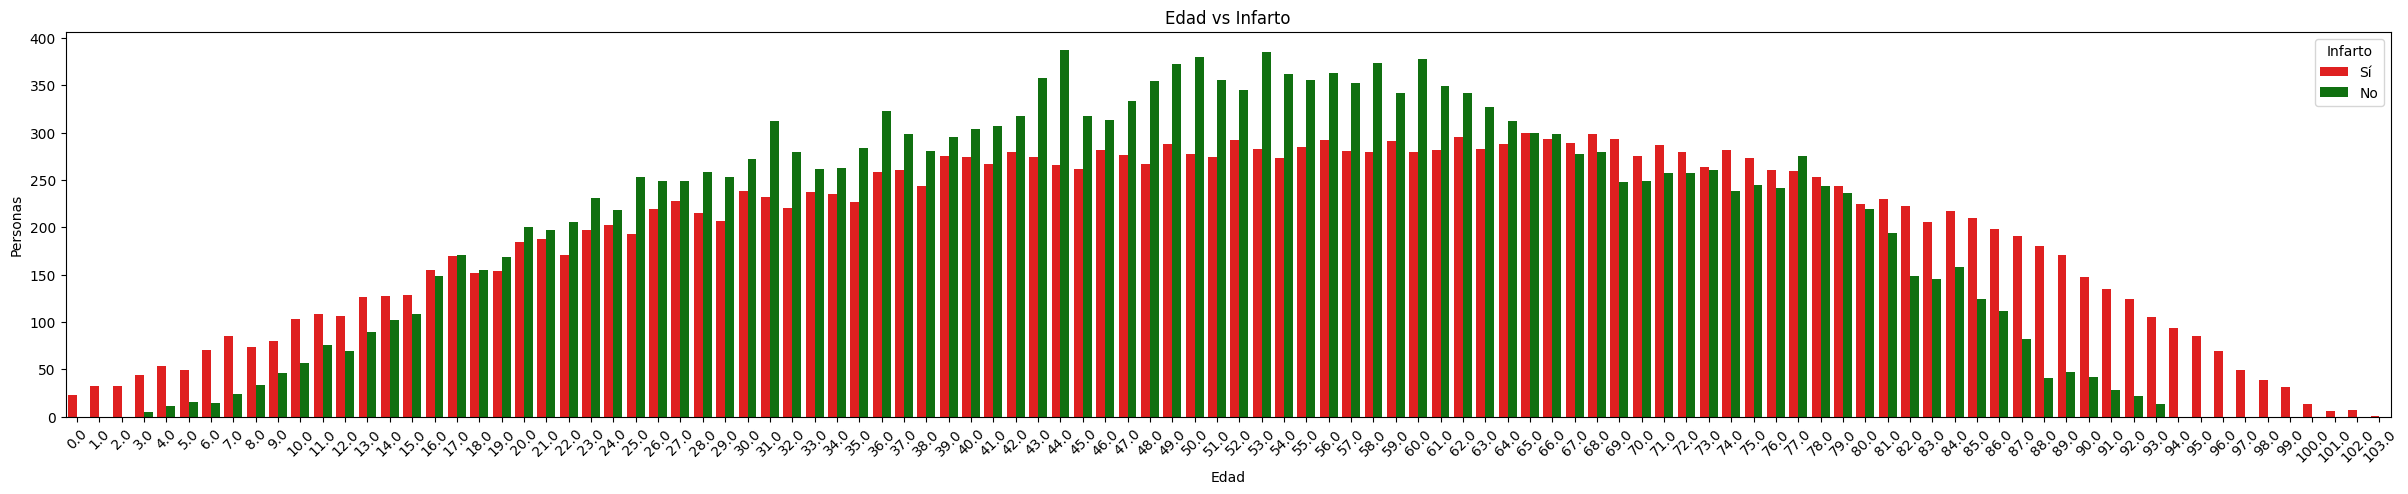

In [17]:
fig, axes = plt.subplots(figsize=(30, 5))

sns.countplot(x=df['Edad'], hue=df['Infarto'], palette=['red', 'green'])
axes.set_title('Edad vs Infarto')
axes.set_ylabel('Personas')
axes.set_xlabel('Edad')
plt.xticks(rotation=45);

Las personas comprendidas entre los 35 y los 65 años tiene un mayor índice de sufir un infarto.

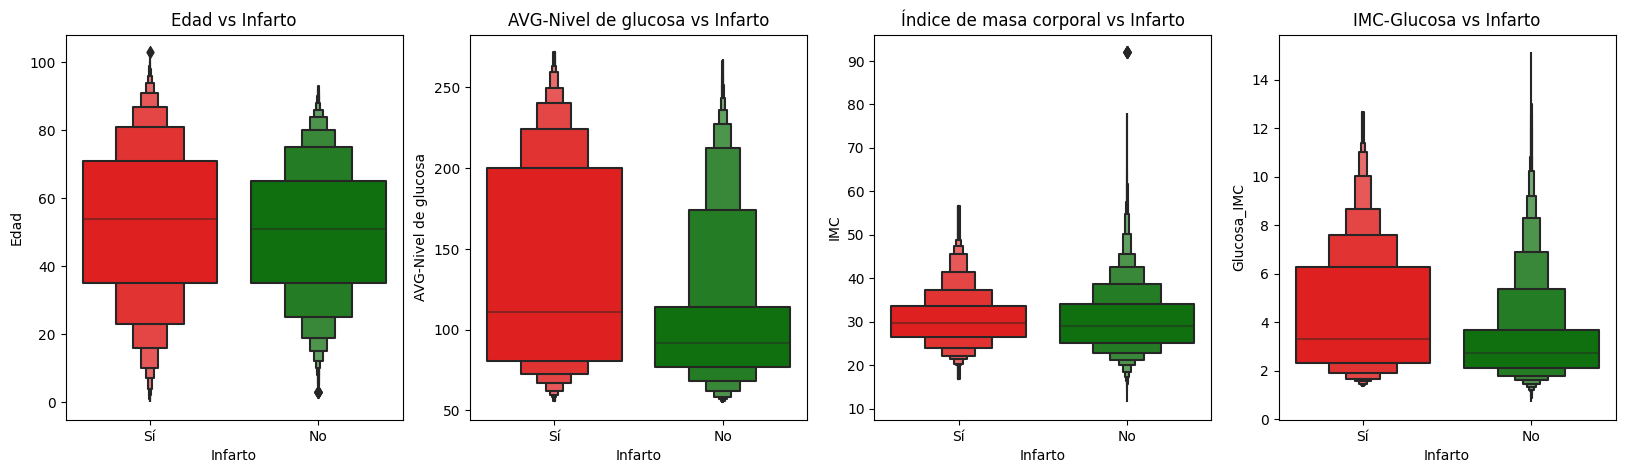

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.boxenplot(data=df, x='Infarto', y='Edad', ax=axes[0], palette=['red', 'green'])
axes[0].set_title('Edad vs Infarto')

sns.boxenplot(data=df, x='Infarto', y='AVG-Nivel de glucosa', ax=axes[1], palette=['red', 'green'])
axes[1].set_title('AVG-Nivel de glucosa vs Infarto')

sns.boxenplot(data=df, x='Infarto', y='IMC', ax=axes[2], palette=['red', 'green'])
axes[2].set_title('Índice de masa corporal vs Infarto')

sns.boxenplot(data=df, x='Infarto', y='Glucosa_IMC', ax=axes[3], palette=['red', 'green'])
axes[3].set_title('IMC-Glucosa vs Infarto');

La distribución de la edad y el IMC respecto a la target es bastante similar, vemos que la mediana y los percentiles están altamente igualados.

Las personas comprendidas entre los 35 y los 65 años tiene un mayor índice de sufrir un infarto.

Se ve claramente que las personas con el nivel de glucosa alto en sangre tienen más probabilidades de sufrir un infarto que las que tienen valores normales.

Observamos un outlier en el IMC (no infarto).

### Cargamos dataset con los datos normalizados

In [19]:
df = pd.read_csv('../data/train.csv')
df.reset_index(inplace=True)
df = features_engineering(df, convertir_valor=True)
df.head()

,index,Género,Edad,Hipertensión,Cardiopatía,Casado,Tipo de trabajo,Tipo de residencia,AVG-Nivel de glucosa,IMC,Fumador,Infarto,Glucosa_IMC,Hiper_Cardiopatía,Hiper-Cardiopatía
0,0,1.0,0.611650,0,1,1,4,1,0.801265,0.311801,1,1,0.531372,1,Hiper o Cardio
1,1,1.0,0.407767,0,1,1,4,0,0.234512,0.260870,0,1,0.189944,1,Hiper o Cardio
2,2,0.0,0.592233,0,0,1,4,1,0.536008,0.284472,1,1,0.359555,0,Ninguna
3,3,1.0,0.398058,1,0,1,3,0,0.549349,0.155280,0,1,0.240973,1,Hiper o Cardio
4,4,1.0,0.825243,0,0,1,4,1,0.605161,0.217391,1,1,0.325589,0,Ninguna


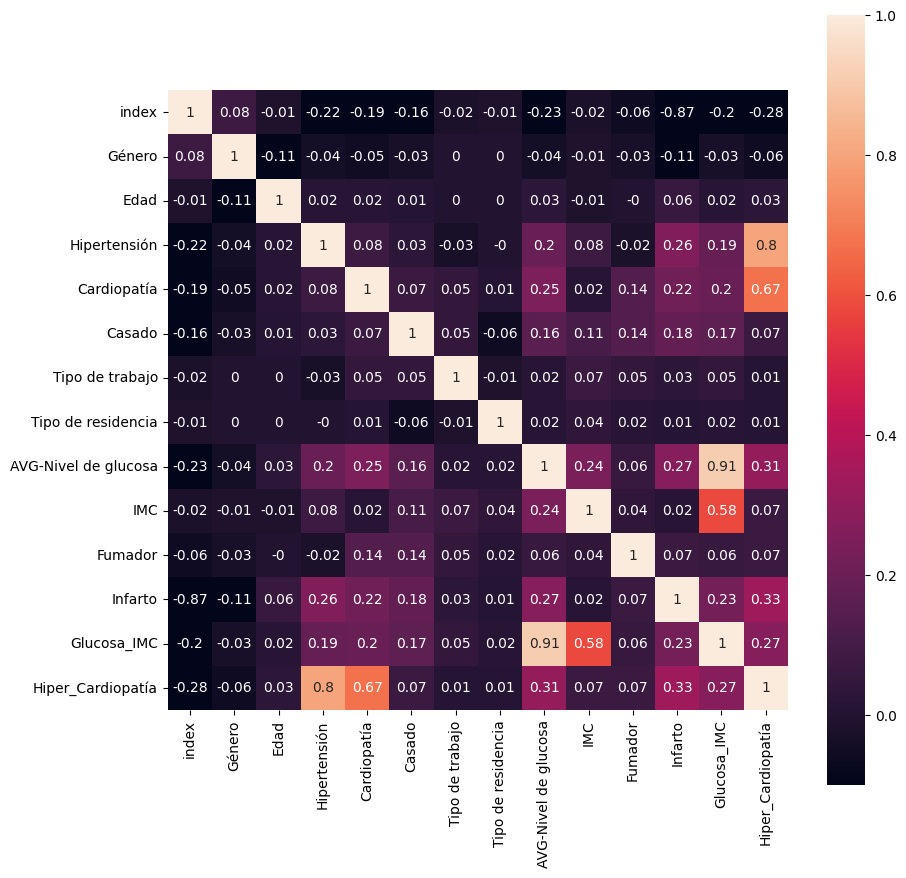

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr().round(2), 
            annot=True, 
            square=True,
            vmin=-0.1,
            vmax=1
            );

Las columnas 'Tipo de residencia', 'IMC', 'Tipo de trabajo', 'Edad' y 'Fumador' (0.01, 0.02, 0.03, 0.06 y 0.07 respectivamente) son las menos correlacionadas con 'Infarto'. El resto tienen una mejor correlación con la target, aunque tampoco son muy buenas.

No hay una correlación mejor de 0,33, le siguen otras de 0.27, 0.26, 0.23 y 0.22.

Vemos una fuerte correlación de 'Hiper-Cardiopatía' con 'Hipertensión' y 'Cardiopatía'. Es normal ya que 'Hiper-Cardiopatía' está creada en base a las otras dos. \
Lo mismo ocurre con 'Glucosa_IMC' y 'AVG-Nivel de glucosa' e 'IMC'.

In [21]:
# 'Género' - 0.11
# 'Edad' - 0.06
# 'Hipertensión' - 0.26
# 'Cardiopatía' - 0.22
# 'Casado' - 0.18
# 'Tipo de trabajo' - 0.03
# 'Tipo de residencia' -  0.01
# 'AVG-Nivel de glucosa' - 0.27
# 'IMC' - 0.02
# 'Fumador' - 0.07
# 'Glucosa_IMC' - 0.23
# 'Hiper_Cardiopatía' - 0.33

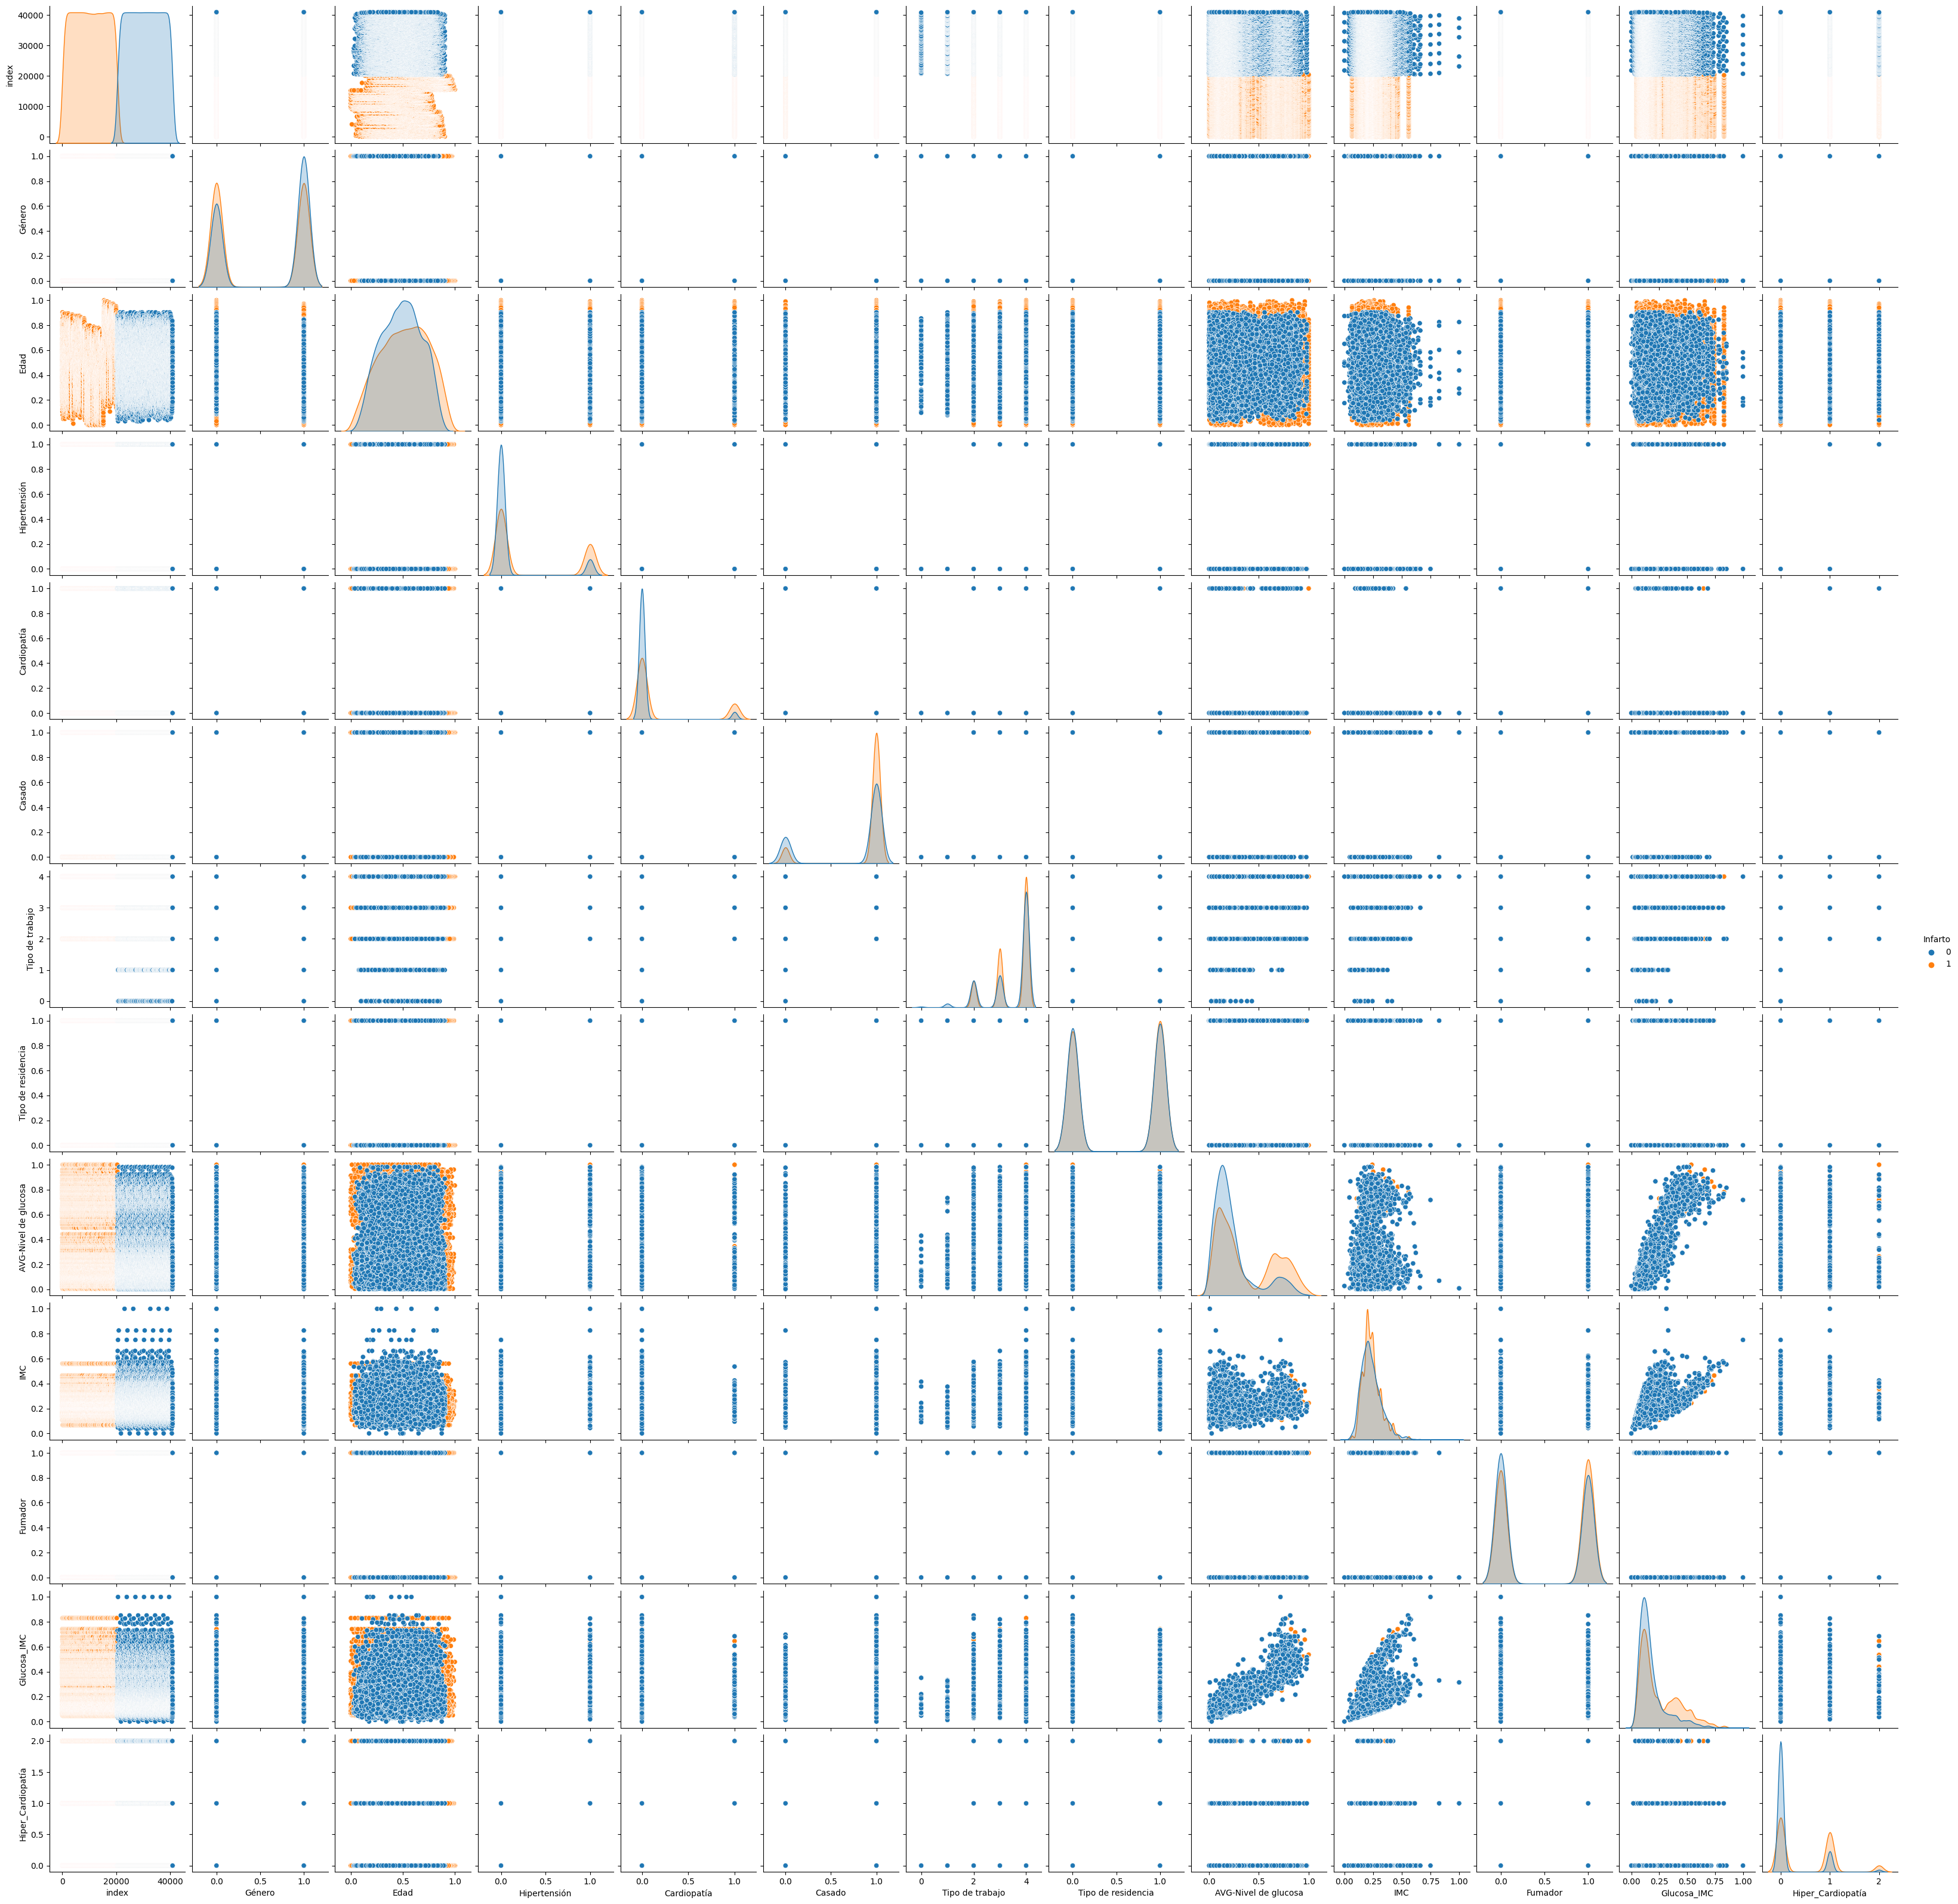

In [22]:
# Variables numericas vs target categórico
sns.pairplot(df,
            kind='scatter',
            hue='Infarto');

In [23]:
df.describe()

,index,Género,Edad,Hipertensión,Cardiopatía,Casado,Tipo de trabajo,Tipo de residencia,AVG-Nivel de glucosa,IMC,Fumador,Infarto,Glucosa_IMC,Hiper_Cardiopatía
count,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000,40849.000000
mean,20465.744890,0.554897,0.499069,0.213592,0.127690,0.821293,3.460942,0.514774,0.309071,0.234855,0.488702,0.499449,0.215217,0.341281
std,11813.961457,0.496983,0.209157,0.409847,0.333748,0.383111,0.781067,0.499788,0.265696,0.084913,0.499878,0.500006,0.157003,0.548901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10221.000000,0.000000,0.339806,0.000000,0.000000,1.000000,3.000000,0.000000,0.109085,0.178882,0.000000,0.000000,0.105063,0.000000
50%,20482.000000,1.000000,0.504854,0.000000,0.000000,1.000000,4.000000,1.000000,0.197720,0.222360,0.000000,0.000000,0.150976,0.000000
75%,30696.000000,1.000000,0.660194,0.000000,0.000000,1.000000,4.000000,1.000000,0.518373,0.280745,1.000000,1.000000,0.296358,1.000000
max,40909.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


### Genera fichero csv de 'Test' para evaluar (20%)

In [24]:
X = df[['index', 'Género', 'Hipertensión', 'Cardiopatía', 'Casado', 'AVG-Nivel de glucosa', 'Glucosa_IMC', 'Hiper_Cardiopatía']]
y = df['Infarto']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_test['Infarto'] = y_test

In [26]:
print(df.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40849, 15)
(32679, 8)
(8170, 9)
(32679,)
(8170,)


In [27]:
df['test'] = np.where(df['index'].isin(X_test['index']), 1, 0)
df['test'].value_counts()

0    32679
1     8170
Name: test, dtype: int64

In [28]:
df.drop(df[(df['test'] == 1)].index, inplace=True)
len(df)

32679

In [29]:
# Eliminamos los campos 'index' y 'test' del df pral

df.drop(columns=['index', 'test'], inplace=True)

In [30]:
# Eliminamos los campos 'index' y 'test' del df de test
X_test.drop(columns=['index'], inplace=True)

# Generamos fichero test
X_test.to_csv('../data/test.csv', index = False) # Muy importante --> index=False

In [31]:
# plt.figure(figsize=(10, 10))
# sns.heatmap(df.corr().round(2), 
#             annot=True, 
#             square=True,
#             vmin=-0.1,
#             vmax=1
#             );

### Separa Train y Validation

In [32]:
X = df[['Género', 'Hipertensión', 'Cardiopatía', 'Casado', 'AVG-Nivel de glucosa', 'Glucosa_IMC', 'Hiper_Cardiopatía']]
y = df['Infarto']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(26143, 7)
(6536, 7)
(26143,)
(6536,)


### PIPELINE

In [33]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# lr_param = {
#     'classifier': [LogisticRegression()],
#     'classifier__penalty': ['l1', 'l2'],
#     'classifier__C': [1, 50, 100, 500],
#     'classifier__solver' : ['saga'],
#     'classifier__max_iter': [100, 500, 1000, 10000],
#     'classifier__class_weight': ['balanced']
# }

lr_param = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__loss': ['deviance', 'exponential'],
    'classifier__min_samples_split': [5, 10, 15]
}

clf = GridSearchCV(estimator=pipe,
                  param_grid=lr_param,
                  cv=10)

clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

### TRAIN

In [34]:
# logit = LogisticRegression(penalty='l2', class_weight='balanced', C=10, max_iter=100) # {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
# logit = GradientBoostingClassifier(n_estimators=150, max_depth=6, loss='exponential') #
# logit = XGBClassifier ()
# logit = SVC(kernel='linear',C=0.1,gamma=0.1)
# logit = RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_split=20) #
# logit = RandomForestClassifier(n_estimators=110, max_depth=6, max_features=3, min_samples_split=15, class_weight='balanced') #
# logit = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=3, class_weight='balanced') #
# logit = DecisionTreeClassifier(max_depth=6, class_weight='balanced', min_samples_split=15)
logit = KNeighborsClassifier(n_neighbors=5) # algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto', weights='distance'
# logit = BaggingClassifier(base_estimator=logit, n_estimators=140)
# llogit = AdaBoostClassifier(base_estimator=logit, n_estimators=150) # , algorithm='SAMME', learning_rate=0.8

In [35]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

logit.fit(X_train_scaled, y_train)

y_pred = logit.predict(X_train_scaled)

fpr, tpr, thresh = roc_curve(y_train, y_pred)
print(auc(fpr, tpr).round(3))
print(roc_auc_score(y_train, y_pred).round(3))
accuracy_score(y_train, y_pred).round(3)

0.99
0.99


0.99

### PREDIC TRAIN

In [36]:
scaler = StandardScaler().fit(X_val)
X_val_scaled = scaler.transform(X_val)

y_pred = logit.predict(X_val_scaled)

fpr, tpr, thresh = roc_curve(y_val, y_pred)
print(auc(fpr, tpr).round(3))
print(roc_auc_score(y_val, y_pred).round(3))
accuracy_score(y_val, y_pred).round(3)

0.951
0.951


0.951

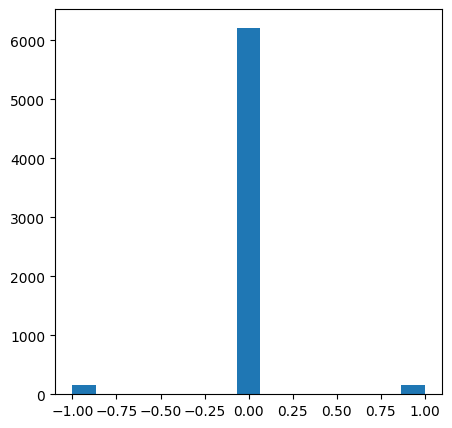

In [37]:
error = y_pred - y_val

plt.figure(figsize=(5, 5))
plt.hist(error, bins=15);

In [38]:
c_mat = confusion_matrix(y_val, y_pred, normalize='true')
c_mat

array([[0.95085008, 0.04914992],
       [0.0487731 , 0.9512269 ]])

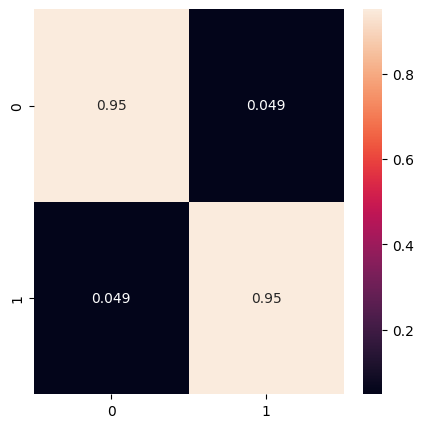

In [39]:
plt.figure(figsize=(5, 5))
sns.heatmap(c_mat, annot=True);

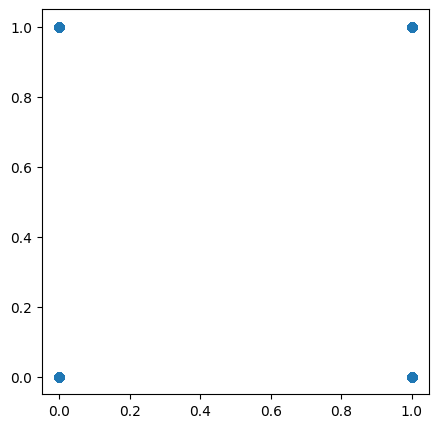

In [40]:
plt.figure(figsize=(5, 5))
plt.scatter(y_val, y_pred);

### EXPORTAR MODELO

In [41]:
# str(now.year)[2:] + str(now.month) + str(now.day) + str(now.hour) + str(now.minute) + str(now.second) # No muestra los 0a la izquierda del mes (02 --> 2), supongo que del día tampoco lo hará.
# '23215125728'

now = datetime.now()
año = now.strftime('%Y')[2:]
timestamp = año + now.strftime('%m%d%H%M%S')
timestamp

filename = '../model/model_' + timestamp
with open(filename, 'wb') as archivo_salida:
    pickle.dump(logit, archivo_salida)

filename_prod = '../model/production/model'
with open(filename_prod, 'wb') as archivo_salida:
    pickle.dump(logit, archivo_salida)
